# Creation of the region-specific masks using Freesurfer's Binarize

### Masks for hippocampus  using FS aparc+aseg

In [13]:
import nipype.pipeline as pe
import nipype.interfaces.io as nio
import os
import nipype.interfaces.freesurfer as fs
from nipype import IdentityInterface

subjects_dir = '/home/data/madlab/surfaces/wmaze'
work_dir = '/scratch/madlab/wmaze/regions_workdir'
sink_dir = '/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c/mask'

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 'WMAZE_007',
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_017', 'WMAZE_018',
        'WMAZE_019', 'WMAZE_020', 'WMAZE_021', 'WMAZE_022', 'WMAZE_23', 'WMAZE_024',
        'WMAZE_026', 'WMAZE_027']

wf = pe.Workflow(name = 'wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(IdentityInterface(fields = ['subject_id'], 
                                          mandatory_inputs = True),
                        name = 'subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

info = dict(ref_epi_file = [['subject_id']],
            bbreg_xfm = [['subject_id']],
            aparc_aseg = [['subject_id']])

# Node: Datagrabber
datasource = pe.Node(nio.DataGrabber(infields = ['subject_id'],
                                     outfields = info.keys()),
                     name = 'datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/')
datasource.inputs.field_template = dict(ref_epi_file = 'data/mri/wmaze/preproc/%s/ref/*.nii.gz',
                                        bbreg_xfm = 'data/mri/wmaze/preproc/%s/bbreg/_fs_register0/*.dat',
                                        aparc_aseg = 'surfaces/wmaze/%s/mri/aparc+aseg.mgz')
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

#### subj_iterable (subject_id) ----> datasource (subject_id)


# MapNode: Create binarized ROI masks
anat_mask = pe.MapNode(fs.Binarize(),
                       iterfield = ['match', 'binary_file'], 
                       name = 'anat_mask')
anat_mask.inputs.match = [[17],[53]] #hippocampus
anat_mask.inputs.binary_file = ['lh-hippocampus.nii.gz','rh-hippocampus.nii.gz']
wf.connect(datasource, 'aparc_aseg', anat_mask, 'in_file')

#### datasource (aparc_aseg) ----> anat_mask (in_file)


# MapNode: Transform the masks to 1st volume of 1st run (EPI space)
anatmask_xfm = pe.MapNode(fs.ApplyVolTransform(inverse = True,
                                               interp = 'nearest'),
                          iterfield = ['target_file'],
                          name = 'anatmask_xfm')
anatmask_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', anatmask_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', anatmask_xfm, 'reg_file')
wf.connect(anat_mask, 'binary_file', anatmask_xfm, 'target_file')

#### datasource (ref_epi_file) ----> anatmask_xfm (source_file)
#### datasource (bbreg_xfm) ----> anatmask_xfm (reg_file)
#### datasource (binary_file) ----> anatmask_xfm (target_file)


# Node: Datasink
sinker = pe.Node(nio.DataSink(infields = None),
                 name = "sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(anatmask_xfm, 'transformed_file', sinker, 'anat_masks')

#### anatmask_xfm (transformed_file) ----> sinker (anat_masks)

wf.run(plugin = 'LSF', plugin_args = {'bsub_args': '-q PQ_madlab'})

170817-03:43:38,793 workflow INFO:
	 ['check', 'execution', 'logging']
170817-03:43:39,141 workflow INFO:
	 Running in parallel.
170817-03:43:39,153 workflow INFO:
	 Pending[0] Submitting[20] jobs Slots[inf]
170817-03:43:39,155 workflow INFO:
	 Submitting: datasource.a03 ID: 0
170817-03:43:39,341 workflow INFO:
	 Finished submitting: datasource.a03 ID: 0
170817-03:43:39,345 workflow INFO:
	 Submitting: datasource.a08 ID: 1
170817-03:43:39,497 workflow INFO:
	 Finished submitting: datasource.a08 ID: 1
170817-03:43:39,500 workflow INFO:
	 Submitting: datasource.a17 ID: 3
170817-03:43:39,650 workflow INFO:
	 Finished submitting: datasource.a17 ID: 3
170817-03:43:39,653 workflow INFO:
	 Submitting: datasource.a02 ID: 7
170817-03:43:39,806 workflow INFO:
	 Finished submitting: datasource.a02 ID: 7
170817-03:43:39,810 workflow INFO:
	 Submitting: datasource.a16 ID: 9
170817-03:43:39,991 workflow INFO:
	 Finished submitting: datasource.a16 ID: 9
170817-03:43:39,995 workflow INFO:
	 Submitting

### Use Glob to grab all newly created anatomy masks and 2nd lvl cope files

In [19]:
from glob import glob

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c/mask/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(mask_filenames_glob)

    subjcopes_glob = glob(proj_dir + '/scndlvl/wmaze_MRthesis/fixed_before_conditional/model0/' + SID + '/fixedfx/cope_*')
    cope_files.append(subjcopes_glob)
    if len(cope_files[-1]) == 0:
        print(SID)
    

In [20]:
print(mask_filenames[0][0]) #Left hippocampus
print(mask_filenames[0][1]) #Right hippocampus

print(cope_files[0][0]) #corr_B_after_A
print(cope_files[0][1]) #incorr_B_after_A
print(cope_files[0][2]) #corr_B_after_C
print(cope_files[0][3]) #incorr_B_after_C
print(cope_files[0][4]) #AB_corr_minus_AB_incorr
print(cope_files[0][5]) #AB_incorr_minus_AC_corr
print(cope_files[0][6]) #CB_corr_minus_CB_incorr
print(cope_files[0][7]) #CB_incorr_minus_CB_corr
print(cope_files[0][8]) #all_corr_vs_all_incorr
print(cope_files[0][9]) #all_incorr_vs_all_corr
for i in cope_files:
    print(len(i))

/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-hippocampus_warped.nii.gz
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm1/rh-hippocampus_warped.nii.gz
/home/data/madlab/data/mri/wmaze/scndlvl/wmaze_MRthesis/fixed_before_conditional0/WMAZE_001/fixedfx/cope_corr_B_after_A.nii.gz
/home/data/madlab/data/mri/wmaze/scndlvl/wmaze_MRthesis/fixed_before_conditional0/WMAZE_001/fixedfx/cope_incorr_B_after_A.nii.gz
/home/data/madlab/data/mri/wmaze/scndlvl/wmaze_MRthesis/fixed_before_conditional0/WMAZE_001/fixedfx/cope_corr_B_after_C.nii.gz
/home/data/madlab/data/mri/wmaze/scndlvl/wmaze_MRthesis/fixed_before_conditional0/WMAZE_001/fixedfx/cope_incorr_B_after_C.nii.gz
/home/data/madlab/data/mri/wmaze/scndlvl/wmaze_MRthesis/fixed_before_conditional0/WMAZE_001/fixedfx/cope_AB_corr_minus_AB_incorr.nii.gz
/home/data/madlab/data/mri/wmaze/scndlvl/wmaze_MRthesis/fixed_before

### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [21]:
import nibabel as nb
import pandas as pd
import numpy as np


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            'lhhp_corr_B_after_A':[], 'rhhp_corr_B_after_A':[],
            'lhhp_incorr_B_after_A':[], 'rhhp_incorr_B_after_A':[],
            'lhhp_corr_B_after_C':[], 'rhhp_corr_B_after_C':[],
            'lhhp_incorr_B_after_C':[], 'rhhp_incorr_B_after_C':[],
            'lhhp_AB_corr_minus_AB_incorr':[], 'rhhp_AB_corr_minus_AB_incorr':[], 
            'lhhp_AB_incorr_minus_AB_corr':[], 'rhhp_AB_incorr_minus_AB_corr':[],
            'lhhp_CB_corr_minus_CB_incorr':[], 'rhhp_CB_corr_minus_CB_incorr':[], 
            'lhhp_CB_incorr_minus_CB_corr':[], 'rhhp_CB_incorr_minus_CB_corr':[],
            'lhhp_all_corr_vs_all_incorr':[], 'rhhp_all_corr_vs_all_incorr':[], 
            'lhhp_all_incorr_vs_all_corr':[], 'rhhp_all_incorr_vs_all_corr':[]}


# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][0])
    rh_hp_img = nb.load(mask_filenames[i][1])

    
    #Load copes for individual trial types
    corr_B_after_A_img = nb.load(cope_files[i][0])
    incorr_B_after_A_img = nb.load(cope_files[i][1])
    corr_B_after_C_img = nb.load(cope_files[i][2])
    incorr_B_after_C_img = nb.load(cope_files[i][3])
    AB_corr_minus_AB_incorr_img = nb.load(cope_files[i][4])
    AB_incorr_minus_AB_corr_img = nb.load(cope_files[i][5])
    CB_corr_minus_CB_incorr_img = nb.load(cope_files[i][6])
    CB_incorr_minus_CB_corr_img = nb.load(cope_files[i][7])
    all_corr_vs_all_incorr_img = nb.load(cope_files[i][8])
    all_incorr_vs_all_corr_img = nb.load(cope_files[i][9])
    
    
    #Left Hippocampus
    # corr_B_after_A
    lh_hp_corr_B_after_A_data = corr_B_after_A_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_corr_B_after_A'].append(np.mean(lh_hp_corr_B_after_A_data))
    
    # incorr_B_after_A
    lh_hp_incorr_B_after_A_data = incorr_B_after_A_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_incorr_B_after_A'].append(np.mean(lh_hp_incorr_B_after_A_data))
    
    # corr_B_after_C
    lh_hp_corr_B_after_C_data = corr_B_after_C_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_corr_B_after_C'].append(np.mean(lh_hp_corr_B_after_C_data))
    
    # incorr_B_after_C
    lh_hp_incorr_B_after_C_data = incorr_B_after_C_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_incorr_B_after_C'].append(np.mean(lh_hp_incorr_B_after_C_data))
    
    # AB_corr_minus_AB_incorr
    lh_hp_AB_corr_minus_AB_incorr_data = AB_corr_minus_AB_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_AB_corr_minus_AB_incorr'].append(np.mean(lh_hp_AB_corr_minus_AB_incorr_data)) 
    
    # AB_incorr_minus_AB_corr
    lh_hp_AB_incorr_minus_AB_corr_data = AB_incorr_minus_AB_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_AB_incorr_minus_AB_corr'].append(np.mean(lh_hp_AB_incorr_minus_AB_corr_data)) 
    
    # CB_corr_minus_CB_incorr
    lh_hp_CB_corr_minus_CB_incorr_data = CB_corr_minus_CB_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_CB_corr_minus_CB_incorr'].append(np.mean(lh_hp_CB_corr_minus_CB_incorr_data)) 
    
    # CB_incorr_minus_CB_corr
    lh_hp_CB_incorr_minus_CB_corr_data = CB_incorr_minus_CB_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_CB_incorr_minus_CB_corr'].append(np.mean(lh_hp_CB_incorr_minus_CB_corr_data)) 
    
    # all_corr_vs_all_incorr
    lh_hp_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_corr_vs_all_incorr'].append(np.mean(lh_hp_all_corr_vs_all_incorr_data)) 
    
    # all_incorr_vs_all_corr
    lh_hp_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_incorr_vs_all_corr'].append(np.mean(lh_hp_all_incorr_vs_all_corr_data)) 
    
    
    #Right Hippocampus
    # corr_B_after_A
    rh_hp_corr_B_after_A_data = corr_B_after_A_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_corr_B_after_A'].append(np.mean(rh_hp_corr_B_after_A_data))
    
    # incorr_B_after_A
    rh_hp_incorr_B_after_A_data = incorr_B_after_A_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_incorr_B_after_A'].append(np.mean(rh_hp_incorr_B_after_A_data))
    
    # corr_B_after_C
    rh_hp_corr_B_after_C_data = corr_B_after_C_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_corr_B_after_C'].append(np.mean(rh_hp_corr_B_after_C_data))
    
    # incorr_B_after_C
    rh_hp_incorr_B_after_C_data = incorr_B_after_C_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_incorr_B_after_C'].append(np.mean(rh_hp_incorr_B_after_C_data))
    
    # AB_corr_minus_AB_incorr
    rh_hp_AB_corr_minus_AB_incorr_data = AB_corr_minus_AB_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_AB_corr_minus_AB_incorr'].append(np.mean(rh_hp_AB_corr_minus_AB_incorr_data)) 
    
    # AB_incorr_minus_AB_corr
    rh_hp_AB_incorr_minus_AB_corr_data = AB_incorr_minus_AB_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_AB_incorr_minus_AB_corr'].append(np.mean(rh_hp_AB_incorr_minus_AB_corr_data)) 
    
    # CB_corr_minus_CB_incorr
    rh_hp_CB_corr_minus_CB_incorr_data = CB_corr_minus_CB_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_CB_corr_minus_CB_incorr'].append(np.mean(rh_hp_CB_corr_minus_CB_incorr_data)) 
    
    # CB_incorr_minus_CB_corr
    rh_hp_CB_incorr_minus_CB_corr_data = CB_incorr_minus_CB_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_CB_incorr_minus_CB_corr'].append(np.mean(rh_hp_CB_incorr_minus_CB_corr_data)) 
    
    # all_corr_vs_all_incorr
    rh_hp_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_corr_vs_all_incorr'].append(np.mean(rh_hp_all_corr_vs_all_incorr_data)) 
    
    # all_incorr_vs_all_corr
    rh_hp_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_incorr_vs_all_corr'].append(np.mean(rh_hp_all_incorr_vs_all_corr_data)) 

    
all_data_df = pd.DataFrame(all_data)

### Combine the two hemispheres to create one regional average

In [22]:
#Hippocampus average for each trial type
all_data_df['hp_corr_B_after_A'] = (all_data_df['lhhp_corr_B_after_A'] + all_data_df['rhhp_corr_B_after_A'])/2.
all_data_df['hp_incorr_B_after_A'] = (all_data_df['lhhp_incorr_B_after_A'] + all_data_df['rhhp_incorr_B_after_A'])/2.
all_data_df['hp_corr_B_after_C'] = (all_data_df['lhhp_corr_B_after_C'] + all_data_df['rhhp_corr_B_after_C'])/2.
all_data_df['hp_incorr_B_after_C'] = (all_data_df['lhhp_incorr_B_after_C'] + all_data_df['rhhp_incorr_B_after_C'])/2.
all_data_df['hp_AB_corr_minus_AB_incorr'] = (all_data_df['lhhp_AB_corr_minus_AB_incorr'] + 
                                             all_data_df['rhhp_AB_corr_minus_AB_incorr'])/2.
all_data_df['hp_AB_incorr_minus_AB_corr'] = (all_data_df['lhhp_AB_incorr_minus_AB_corr'] + 
                                             all_data_df['rhhp_AB_incorr_minus_AB_corr'])/2.
all_data_df['hp_CB_corr_minus_CB_incorr'] = (all_data_df['lhhp_CB_corr_minus_CB_incorr'] + 
                                             all_data_df['rhhp_CB_corr_minus_CB_incorr'])/2.
all_data_df['hp_CB_incorr_minus_CB_corr'] = (all_data_df['lhhp_CB_incorr_minus_CB_corr'] + 
                                             all_data_df['rhhp_CB_incorr_minus_CB_corr'])/2.
all_data_df['hp_all_corr_vs_all_incorr'] = (all_data_df['lhhp_all_corr_vs_all_incorr'] + 
                                            all_data_df['rhhp_all_corr_vs_all_incorr'])/2.
all_data_df['hp_all_incorr_vs_all_corr'] = (all_data_df['lhhp_all_incorr_vs_all_corr'] + 
                                            all_data_df['rhhp_all_incorr_vs_all_corr'])/2.

## Hippocampus Activation: Fixed Before Conditional Trials

In [23]:
from scipy import stats

print 'corr_B_after_A mean'
print all_data_df['hp_corr_B_after_A'].mean()
print 'incorr_B_after_A'
print all_data_df['hp_incorr_B_after_A'].mean()
print 'corr_B_after_C mean'
print all_data_df['hp_corr_B_after_C'].mean()
print 'incorr_B_after_C mean'
print all_data_df['hp_incorr_B_after_C'].mean()



print 'T-test: Hippocampus corr_B_after_A vs. incorr_B_after_A'
print stats.ttest_rel(all_data_df['hp_corr_B_after_A'], all_data_df['hp_incorr_B_after_A'])
print 'T-test: Hippocampus corr_B_after_C vs. incorr_B_after_C'
print stats.ttest_rel(all_data_df['hp_corr_B_after_C'], all_data_df['hp_incorr_B_after_C'])

print 'ANOVA: Hippocampus corr_B_after_A vs. incorr_B_after_A vs. corr_B_after_C vs. incorr_B_after_C'
print stats.f_oneway(all_data_df['hp_corr_B_after_A'], all_data_df['hp_incorr_B_after_A'],
                     all_data_df['hp_corr_B_after_C'], all_data_df['hp_incorr_B_after_C'])

corr_B_after_A mean
-0.356258544768
incorr_B_after_A
-1.75675775371
corr_B_after_C mean
-0.332649694383
incorr_B_after_C mean
-1.67358596814
T-test: Hippocampus corr_B_after_A vs. incorr_B_after_A
Ttest_relResult(statistic=3.6974118777482259, pvalue=0.001528736336762181)
T-test: Hippocampus corr_B_after_C vs. incorr_B_after_C
Ttest_relResult(statistic=3.2288136768375884, pvalue=0.0044190990549709428)
ANOVA: Hippocampus corr_B_after_A vs. incorr_B_after_A vs. corr_B_after_C vs. incorr_B_after_C
F_onewayResult(statistic=4.2008879425779462, pvalue=0.0083448928878836464)


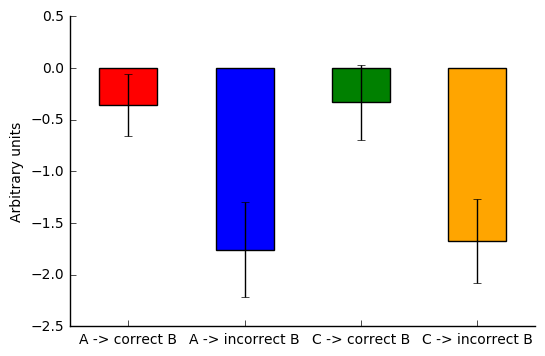

In [24]:
import matplotlib.pyplot as plt

N = 4
conditions = ['A -> correct B', 'A -> incorrect B', 'C -> correct B', 'C -> incorrect B']
bar_colors = ['red', 'blue', 'green', 'orange']
hp_means_allsubjs = [all_data_df['hp_corr_B_after_A'].mean(), 
                     all_data_df['hp_incorr_B_after_A'].mean(), 
                     all_data_df['hp_corr_B_after_C'].mean(),
                     all_data_df['hp_incorr_B_after_C'].mean()]
hp_sem_allsubjs = [all_data_df['hp_corr_B_after_A'].std()/(np.sqrt(len(sids))), 
                   all_data_df['hp_incorr_B_after_A'].std()/(np.sqrt(len(sids))),
                   all_data_df['hp_corr_B_after_C'].std()/(np.sqrt(len(sids))),
                   all_data_df['hp_incorr_B_after_C'].std()/(np.sqrt(len(sids)))]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.bar(ind, hp_means_allsubjs, width, color = bar_colors, ecolor = 'black', 
       yerr = hp_sem_allsubjs, align = 'center', bottom = 0)
#ax.boxplot([all_data_df['hp_ACtrials'],all_data_df['hp_Btrials']], positions=[1,2])

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")

plt.show()